In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from tqdm.notebook import tqdm
from typing import List, Tuple, Union
import time

# Some Utility Functions

In [73]:
def read_json(fpath: str):
    with open(fpath, "r") as f:
        data = json.load(f)
        f.close()
    return data

root_output_path = "../data/output"
file_list = [fname for fname in os.listdir(root_output_path) if fname.endswith(".json")]
file_list

['data_princeton-nlp-Sheared-LLaMA-1-3B_n500_synthid.json',
 'data_facebook-opt-1-3b_n500_pf.json',
 'data_facebook-opt-125m_n500_inverse.json',
 'data_google-gemma-3-270m_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_unwatermarked.json',
 'data_mistralai-Mistral-7B-v0-1_n500_pf.json',
 'data_google-gemma-3-270m_n500_inverse.json',
 'data_meta-llama-Meta-Llama-3-8B_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_redgreen.json',
 'data_google-gemma-3-270m_n500_redgreen.json',
 'data_facebook-opt-1-3b_n500_synthid.json',
 'data_meta-llama-Meta-Llama-3-8B_n500_pf.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_pf.json',
 'data_facebook-opt-125m_n500_unwatermarked.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_gumbel.json',
 'data_mistralai-Mistral-7B-v0-1_n500_redgreen.json',
 'data_mistralai-Mistral-7B-v0-1_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_inverse.json',
 'data_mistralai-Mistral-7B-v0-1_n500_inverse.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_unwaterm

In [74]:
# IOU is the typical metric that is tracked in these scenarios
def get_iou(intervalsA: List[Tuple[int, int]], intervalsB: List[Tuple[int, int]]):
  coordsA = set([x for start, end in intervalsA for x in range(start, end)])
  coordsB = set([x for start, end in intervalsB for x in range(start, end)])
  num = len(coordsA.intersection(coordsB))
  denom = len(coordsA.union(coordsB))
  return (num / denom)

def get_hit_counts(true_intervals: List[Tuple[int, int]], estimated_intervals: List[Tuple[int, int]]):
  # count how many of the true intervals we have nonzero IOU
  hit_count = 0
  est_intervals = estimated_intervals.copy()
  for true_int in true_intervals:
    max_iou = 0
    max_index = None
    for j in range(len(est_intervals)):
      iou = get_iou([true_int], [est_intervals[j]])
      if iou > 0 and iou > max_iou:
        max_iou = iou
        max_index = j
    
    if max_iou > 0 and max_index is not None:
      hit_count += 1
      est_intervals.pop(max_index)

  return hit_count

def get_rand_index(intervalsA: List[Tuple[int, int]], intervalsB: List[Tuple[int, int]], n: int):
  # convert interval endpoints to sorted changepoints for fast computation
  # reference: https://arxiv.org/pdf/2112.03738
  cpA = sorted([0, n] + [x for interval in intervalsA for x in interval])
  cpB = sorted([0, n] + [x for interval in intervalsB for x in interval])
  num = 0
  for i in range(len(cpA) - 1):
    for j in range(len(cpB) - 1):
      nij = max(0, min(cpA[i+1], cpB[j+1]) - max(cpA[i], cpB[j]))
      num += (nij * abs(cpA[i+1] - cpB[j+1]))
  return 1 - 2 * num / (n*(n-1))


# metric to find the symmetric differences
def get_symmetric_difference(intA, intB):
  sA, eA = intA
  sB, eB = intB
  return abs(sA - sB) + abs(eA - eB)

In [75]:
# get summary of detection methods applied for a specific data
def get_summarized_results(data, get_interval_func, add_plot = False, verbose = True):
    metrics_list = []
    interval_endpoints = []
    true_intervals =  [
        (start, end) for (start, end, interval_type) in data['configuration']['intervals'] if interval_type != 'unwatermarked'
    ]

    n = 0
    for sample_index, sample_data in tqdm(list(enumerate(data["data"]))):
        pivots = sample_data["pivots"]
        n = max(n, len(pivots))
        pivots = np.array(pivots)
        pivots[np.isinf(pivots)] = pivots[~np.isinf(pivots)].max() # replace by maximum for infinite values
        est_intervals, time_taken = get_interval_func(pivots)
        
        # add detected endpoints to array
        for left_end, right_end in est_intervals:
            interval_endpoints.append(left_end)
            interval_endpoints.append(right_end)

        # calculate metrics
        hit_count = get_hit_counts(true_intervals, est_intervals)
        metric_row = {
            "sample_index": sample_index,
            "detected_intervals_count": len(est_intervals),
            "iou": get_iou(est_intervals, true_intervals),
            "recall": hit_count / max(len(true_intervals), 1),  # Recall
            "precision": hit_count / max(len(est_intervals), 1),  # Precision
            "rand_index": get_rand_index(true_intervals, est_intervals, n),
            "time": time_taken
        }
        metrics_list.append(metric_row)

    metric_df = pd.DataFrame(metrics_list)
    # metric_df['f1'] = 2 * metric_df['precision'] * metric_df['recall'] / (metric_df['precision'] + metric_df['recall'])
    f1 = 2 * metric_df['precision'].mean() * metric_df['recall'].mean() / (metric_df['precision'].mean() + metric_df['recall'].mean())

    return {
        "model_name": data['configuration']['model_name'],
        "iou": metric_df['iou'].mean(),
        "precision": metric_df['precision'].mean(),
        "recall": metric_df['recall'].mean(),
        "f1": f1,
        "rand_index": metric_df['rand_index'].mean()
    }

    # if verbose:
    #     # print the description of the setup
    #     print(f"Model name: {data['configuration']['model_name']}")
    #     print(f"Output tokens: {data['configuration']['out_tokens']}")
    #     print(f"Vocab size: {data['configuration']['vocab_size']}")
    #     print(f"Segment types: {', '.join([interval_type for start, end, interval_type in data['configuration']['intervals']])}\n")

    #     # Summary 1: Frequency table of # of detected intervals
    #     frequency_table = metric_df['detected_intervals_count'].value_counts().reset_index()
    #     frequency_table.columns = ['value', 'frequency']
    #     frequency_table['proportion'] = frequency_table['frequency'] / frequency_table['frequency'].sum()
    #     print(f"Frequency Table of Detected Intervals: \n{frequency_table.sort_values(by = "frequency", ascending=False).head(5)}")

    #     # Summary 2: Describe the scores
    #     print(f"\nAdditional Metrics: \nMean IOU: {metric_df['iou'].mean()}\nMean Time Taken: {metric_df['time'].mean()}")

    # # draw a histogram of detected intervals endpoints
    # if add_plot:
    #     plt.figure(figsize=(10, 6))
    #     h = sns.histplot(
    #         data=pd.DataFrame({'endpoints': interval_endpoints}),
    #         x='endpoints',
    #         binwidth=n/100
    #     )
    #     plt.vlines(
    #         x=[int(a) for x in true_intervals for a in x],
    #         ymin=h.get_ylim()[0],
    #         ymax = h.get_ylim()[1],
    #         colors="red"
    #     )
    #     plt.title('Histogram of Detected Endpoints')
    #     plt.xlim(0, n)
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.show()

    # return {
    #     "model_name": data['configuration']['model_name'],
    #     "iou": metric_df['iou'].mean(),
    #     "time": metric_df['time'].mean() * 1000
    # }

# Calculate Metrics

In [76]:
from detections import EpidemicDetectorV2, AligatorCPPDetector, WinMaxDetector, FixedWindowDetector, WaterSeekerDetector
from watermarking_func import null_distn_gumbel, null_distn_inverse, null_distn_redgreen, null_distn_synthid, null_distn_pf

In [86]:
# best block sizes for epidemic
# block_size = 65, c = 1

null_dist_list = {
    "gumbel": null_distn_gumbel,
    "inverse": null_distn_inverse,
    "redgreen": null_distn_redgreen,
    "pf": null_distn_pf
}

model_list = [
    "data_facebook-opt-125m_n500",
    "data_google-gemma-3-270m_n500",
    "data_facebook-opt-1-3b_n500",
    "data_princeton-nlp-Sheared-LLaMA-1-3B_n500",
    "data_mistralai-Mistral-7B-v0-1_n500",
    "data_meta-llama-Meta-Llama-3-8B_n500"
]
watermark_method = "pf"
null_distn = null_dist_list[watermark_method]


In [87]:
outputs = []
for fmodel in model_list:
    fname = f"{fmodel}_{watermark_method}.json"
    data = read_json(os.path.join(root_output_path, fname))
    vocab_size = data['configuration']['vocab_size']
    model_name = data['configuration']['model_name']
    print(f"\n\nLoaded file {fname} with model {model_name} and vocab size {vocab_size}\n")

    # Run epidemic
    def get_epidemic_intervals(x):
        d = EpidemicDetectorV2(vocab_size)
        return d.detect(x, null_distn=null_distn, block_size=65, c = 1) 
    
    res = get_summarized_results(data, get_epidemic_intervals, verbose=False)
    res['method'] = "Epidemic"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)


    # Run aligator
    def get_aligator_intervals(x):
        d = AligatorCPPDetector(vocab_size)
        return d.detect(np.array(x), null_distn)
        
    res = get_summarized_results(data, get_aligator_intervals, verbose=False)
    res['method'] = "Aligator"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)

    # # Run winmax
    # def get_winmax_intervals(x):
    #     d = WinMaxDetector(vocab_size)
    #     return d.detect(x, null_distn)
    # res = get_summarized_results(data, get_winmax_intervals, verbose=False)
    # res['method'] = "Winmax"
    # res['model_name'] = model_name
    # res['vocab_size'] = vocab_size
    # outputs.append(res)

    # Run fixed width
    def get_fixedwidth_intervals(x):
        d = FixedWindowDetector(vocab_size)
        return d.detect(x, null_distn)
    res = get_summarized_results(data, get_fixedwidth_intervals, verbose=False)
    res['method'] = "FW"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)
    
    # Run waterseeker
    def get_seek_intervals(x):
        d = WaterSeekerDetector(vocab_size)
        return d.detect(x, null_distn)
    res = get_summarized_results(data, get_seek_intervals, verbose=False)
    res['method'] = "Waterseeker"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)


output_df = pd.DataFrame(outputs)

# output_df = output_df[['model_name', 'vocab_size', 'method', 'iou', 'precision', 'recall', 'f1']].round(3)
# output_df



Loaded file data_facebook-opt-125m_n500_pf.json with model facebook/opt-125m and vocab size 50272



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]



Loaded file data_google-gemma-3-270m_n500_pf.json with model google/gemma-3-270m and vocab size 262144



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]



Loaded file data_facebook-opt-1-3b_n500_pf.json with model facebook/opt-1.3b and vocab size 50272



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]



Loaded file data_princeton-nlp-Sheared-LLaMA-1-3B_n500_pf.json with model princeton-nlp/Sheared-LLaMA-1.3B and vocab size 32000



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]



Loaded file data_mistralai-Mistral-7B-v0-1_n500_pf.json with model mistralai/Mistral-7B-v0.1 and vocab size 32000



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]



Loaded file data_meta-llama-Meta-Llama-3-8B_n500_pf.json with model meta-llama/Meta-Llama-3-8B and vocab size 128256



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [88]:
output_df = output_df[['model_name', 'vocab_size', 'method', 'iou', 'precision', 'recall', 'f1', 'rand_index']].round(3)

# output_df
print(output_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrlrrrrr}
\toprule
model_name & vocab_size & method & iou & precision & recall & f1 & rand_index \\
\midrule
facebook/opt-125m & 50272 & Epidemic & 0.846 & 0.998 & 0.998 & 0.998 & 0.960 \\
facebook/opt-125m & 50272 & Aligator & 0.665 & 0.345 & 0.978 & 0.510 & 0.935 \\
facebook/opt-125m & 50272 & FW & 0.469 & 0.009 & 1.000 & 0.018 & 0.805 \\
facebook/opt-125m & 50272 & Waterseeker & 0.712 & 1.000 & 0.905 & 0.950 & 0.891 \\
google/gemma-3-270m & 262144 & Epidemic & 0.831 & 1.000 & 1.000 & 1.000 & 0.956 \\
google/gemma-3-270m & 262144 & Aligator & 0.558 & 0.252 & 0.952 & 0.399 & 0.906 \\
google/gemma-3-270m & 262144 & FW & 0.507 & 0.008 & 1.000 & 0.016 & 0.833 \\
google/gemma-3-270m & 262144 & Waterseeker & 0.614 & 1.000 & 0.782 & 0.878 & 0.841 \\
facebook/opt-1.3b & 50272 & Epidemic & 0.819 & 1.000 & 0.990 & 0.995 & 0.951 \\
facebook/opt-1.3b & 50272 & Aligator & 0.446 & 0.216 & 0.928 & 0.350 & 0.887 \\
facebook/opt-1.3b & 50272 & FW & 0.517 & 0.008 & 0.992 & 0.017 & 0.83

# Watermark Detection Speed Comparison

In [18]:
from detections import AligatorCPPDetector, FixedWindowDetector, WaterSeekerDetector, EpidemicDetectorV2
from watermarking_func import null_distn_gumbel, null_distn_inverse, null_distn_redgreen, null_distn_pf

In [19]:
from itertools import product
from tqdm.notebook import tqdm

B = 100  # number of replications
vocab_size = 10000
nlist = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 5000, 7500, 10000]

rows = []
for n, b in tqdm(list(product(nlist, range(B)))):
    pivots = np.random.standard_exponential(size = n)  # (n, )  # generate sample gumbel pivots
    random_index = int(np.random.rand() * n/2)
    pivots[random_index:(random_index + int(n/6))] += 5  # create some simulated wm segments

    # run aligator
    d = AligatorCPPDetector(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "Aligator", "time": t })

    # run fw
    d = FixedWindowDetector(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "FW", "time": t })

    # run waterseeker
    d = WaterSeekerDetector(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "Waterseeker", "time": t })

    # run epidemic
    d = EpidemicDetectorV2(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "Epidemic", "time": t })


timedf = pd.DataFrame(rows)
timedf.head()


  0%|          | 0/1200 [00:00<?, ?it/s]

,index,n,method,time
0,0,100,Aligator,0.003659
1,0,100,FW,0.000077
2,0,100,Waterseeker,0.000155
3,0,100,Epidemic,0.000082
4,1,100,Aligator,0.003758


(4800, 4)


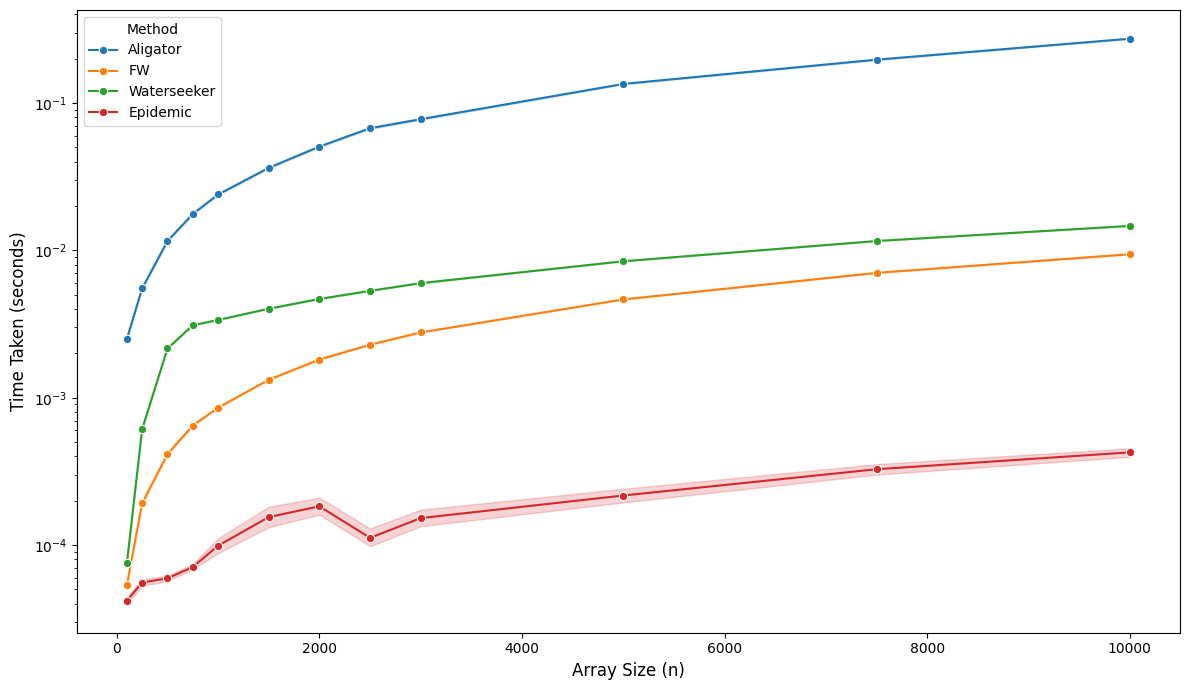

In [23]:
print(timedf.shape)

plt.figure(figsize=(12, 7))
plot = sns.lineplot(
    data=timedf,
    x='n',
    y='time',
    hue='method',
    marker='o',
    errorbar=('ci', 95) # 'ci' shows the 95% confidence interval
)

# plot.set_xscale('log')  # plot in log scale
plot.set_yscale('log')

# plot.set_title('Method Performance vs. Array Size (n)', fontsize=16, weight='bold')
plot.set_xlabel('Array Size (n)', fontsize=12)
plot.set_ylabel('Time Taken (seconds)', fontsize=12)
plt.legend(title='Method', fontsize=10)
plt.tight_layout() # Adjust layout to make sure everything fits